# 1 - Overview

Twitter is a mix of social network and microblogging. In this network, people post information and communicate among themselves through messages, called tweets, that can contain up to 280 characters. In this assignment, *we will implement a prototype that can detect if an airline company is positively or negatively mentioned in a tweet*. 



# 2 - Sentiment Analysis Model (13 points)

In the literature, the task of extracting the sentiment of a text is called *sentiment analysis*. We will implement a bag-of-words (BoW) model for this task.

## 2.1 -  Setup

Please run the code below to install the packages needed for this assignment.

In [1]:
# If you want, you can use anaconda and install after nltk library
!pip install --upgrade --user pip
!pip install --user numpy
!pip install --user sklearn
!pip install --user scipy
!pip install --user nltk


#python
import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

Requirement already up-to-date: pip in /home/gregoire/.local/lib/python3.6/site-packages (19.1.1)


[nltk_data] Downloading package punkt to /home/gregoire/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gregoire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gregoire/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/gregoire/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 2.2 - Dataset

Please download the zip file in the following url: https://drive.google.com/file/d/1iGmESwPXpO3sIZFGOCrysxJ27AHdly-Y/view?usp=sharing

In this zip file, there are 2 files:
1. train.tsv: training dataset
2. dev.tsv: validation dataset

Each line of the files has the following information about a tweet: *tweet id*, *user id*, *label* and *message text*.

There are three labels in the dataset: *negative*, *neutral* and *positive*. We represent each one of these labels as 0, 1 and 2 respectively.

In the code above read the training and validation datasets.

In [2]:
import codecs
import re
import math

def load_dataset(path):
    dtFile = codecs.open(path, 'r')
    
    x = []
    y = []
    
    for l in dtFile:
        sid, uid, label,text = re.split(r"\s+", l, maxsplit=3)
        
        text = text.strip()
        
        # Remove not available
        if text == "Not Available":
            continue
        
        x.append(text)
        
        if label == "negative": 
            y.append(0)
        elif label == "neutral": 
            y.append(1)
        elif label == "positive": 
            y.append(2)
        
    assert len(x) == len(y)
            
    return x,y
            

# Path of training dataset
trainingPath="./train_data.tsv"

# Path of validation dataset
validationPath="./dev_data.tsv"

training_X, training_Y = load_dataset(trainingPath)
validation_X, validation_Y = load_dataset(validationPath)
print(len(training_X))
print(len(training_Y))
print(len(validation_X))
print(len(validation_Y))

263
263
137
137


## 2.3 - Preprocessing

Preprocessing is a crucial task in data mining. This task clean and transform the raw data in a format that can better suit data analysis and machine learning techniques. In natural language processing (NLP), *tokenization* and *stemming* are two well known preprocessing steps. Besides these two steps, we will implement an additional step that is designed exclusively for the twitter domain.

### 2.3.1 - Tokenization

In this preprocessing step, a *tokenizer* is responsible for breaking a text in a sequence of tokens (words, symbols, and punctuations). For instance, the sentence *"It's the student's notebook."* can be split into the following list of tokens: ['It', "'s", 'the', 'student', "'s", 'notebook', '.'].


#### 2.3.1.1 - Question 1 (0.5 point) 

Implement the SpaceTokenizer and NLTKTokenizer tokenizers: 
- **SpaceTokenizer** tokenizes the tokens that are separated by whitespace (space, tab, newline). This is a naive tokenizer.
- **NLTKTokenizer** uses the default method of the nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.

**All tokenizers have to lowercase the tokens.**

In [3]:
class SpaceTokenizer(object):
    """
    It tokenizes the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.
    
    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """
    
    def tokenize(self, text):
        try:
            tokens = text.split()
        except:
            raise NotImplementedError("space tokenize error")
        return tokens
        
class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """
    
    def tokenize(self, text):
        try:
            tokens = nltk.word_tokenize(text)
        except:
            raise NotImplementedError("nltk tokenize error")
        
        # Have to return a list of tokens
        return tokens

In [4]:
tk = NLTKTokenizer()
print(tk.tokenize("je suis pas bo"))
tk = SpaceTokenizer()
print(tk.tokenize("je suis pas bo"))

['je', 'suis', 'pas', 'bo']
['je', 'suis', 'pas', 'bo']


### 2.3.2 - Stemming

In the tweets *"I should have bought a new shoes today"* and *"I spent too much money buying games"*, the words *"buy"* and *"bought"* represent basically the same concept. Considering both words as different can unnecessarily increase the dimensionality of the problem and can negatively impact the performance of simple models. Therefore, a unique form (e.g., the root buy) can represent both words. The process to convert words with the same stem (word reduction that keeps word prefixes) to a standard form is called *stemming*.

#### 2.3.2.1 - Question 2 (0.5 point) 

Retrieve the stems of the tokens using the attribute *stemmer* from the class *Stemmer*.

In [5]:
from nltk.stem.snowball import SnowballStemmer

class Stemmer(object):
    
    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    def stem(self, tokens):
        """
        tokens: a list of strings
        """
        try:
            tokens = [self.stemmer.stem(token) for token in tokens]
        except:
            raise NotImplementedError("")
        
        return tokens

In [6]:
st = Stemmer().stemmer
words = ['buying', 'bought', 'running', 'was', 'reported','generously']
output = [st.stem(word) for word in words]
print(output)

['buy', 'bought', 'run', 'was', 'report', 'generous']


### 2.3.3 - Twitter preprocessing

Sometimes only applying the default NLP preprocessing steps is not enough. Data for certain domains can have peculiar characteristics which requires specific preprocessing steps to remove the noise and create a more suitable format for the models. 

In NLP, methods store a set of words, called dictionary, and all the words out of the dictionary are considered as unknown. In this assignment, the feature space dimensionality of a model is directly related to the number of words in the dictionary. Since high-dimensional spaces can suffer from the curse of dimensionality, our goal is to create preprocessing steps that decrease vocabulary size.  

#### 2.3.3.1 - Question 3 (2.0 points)

Briefly explain and implement at least two preprocessing steps that reduce the dictionary size (number of unique words). These preprocessing steps must be related to the specific characteristic of the Twitter data. Therefore, for instance, the stop words removal will not be accepted as a preprocessing step.

In [7]:
import re
class TwitterPreprocessing(object):
    
    def preprocess(self, tweet):
        """
        tweet: original tweet
        """
        try:
            if tweet == "Not Available":
                return tweet
            # on retire les mots qui commencent par des @ (tags) et http (liens)
            tweet = re.sub("(http|@)[^ \t\n\r]*([\s]|$)", "", tweet)
            # on retire les #
            tweet = re.sub("#", "", tweet)
            # on remplace les chiffres par des espaces
            tweet = re.sub("[0-9]", " ", tweet)
            
        except:
            raise NotImplementedError("")
    
        # return the preprocessed twitter
        return tweet

In [8]:
prepro = TwitterPreprocessing()
print(prepro.preprocess("@juju #coucou https://moodle.polymtl.ca gregoire hello2 @coucou https://moodle.polymtl.ca"))

coucou gregoire hello  


### 2.3.3  Pipeline

The pipeline is sequence of preprocessing steps that transform the raw data to a format that is suitable for your problem. We implement the class *PreprocessingPipeline* that apply the tokenizer, twitter preprocessing and stemer to the text.

**Feel free to change the preprocessing order.**

In [9]:
class PreprocessingPipeline:
    
    def __init__(self, tokenization, twitterPreprocessing, stemming):
        """
        tokenization: enable or disable tokenization.
        twitterPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer= NLTKTokenizer() if tokenization else SpaceTokenizer()
        self.twitterPreprocesser = TwitterPreprocessing() if twitterPreprocessing else None
        self.stemmer = Stemmer() if stemming else None
    
    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        twitterPreprocessing: boolean value. Apply the
        stemming: boolean value.
        """
        if self.twitterPreprocesser:
            tweet = self.twitterPreprocesser.preprocess(tweet)
        
        tokens = self.tokenizer.tokenize(tweet)

        if self.stemmer:
            tokens = self.stemmer.stem(tokens)
            
        

        return tokens

In [10]:
pre_process_pipe = PreprocessingPipeline(True, True, True)

## 2.4 N-grams

An n-gram is a contiguous sequence of *n* tokens from a text. Thus, for instance,the sequence *"bye as"* and *"walked through"* are example of 2-grams from the sentence *"He said bye as he walked through the door ."*. 1-gram, 2-gram and 3-gram are, respectively, called unigram, bigram and trigram. We list all the possible unigram, bigram and trigram from the *"He said bye as he walked through the door ."*:

- Unigram: ["He", "said", "bye", "as", "he", "walked", "through", "the", "door", "."]
- Bigram: ["He said", "said bye", "bye as", "as he", "he walked", "walked through", "through the", "the door", "door ."] 
- Trigram: ["He said bye", "said bye as", "bye as he", "as he walked", "he walked through", "walked through the", "through the door", "the door ."] 


### 2.4.1 - Question 4 (1 point)

Implement bigram and trigram.

**For this exercise, you cannot use any external python library (e.g., scikit-learn).**

In [11]:
def bigram(tokens):
    """
    tokens: a list of strings
    """
    len_tokens = len(tokens)
    bigram = []
    i = 0
    while i < len_tokens - 1:
        bigram.append(tokens[i] + ' ' + tokens[i + 1])
        i+=1
    return bigram
        
    
def trigram(tokens):
    """
    tokens: a list of strings
    """
    len_tokens = len(tokens)
    trigram = []
    i = 0
    while i < len_tokens - 2:
        trigram.append(tokens[i] + ' ' + tokens[i + 1] + ' ' + tokens[i + 2])
        i+=1
    return trigram

In [12]:
print(bigram(['coucou', 'la', 'compagnie', '!']))
print(trigram(['coucou', 'la', 'compagnie', '!']))

['coucou la', 'la compagnie', 'compagnie !']
['coucou la compagnie', 'la compagnie !']


## 2.5 Bag-of-words

Logistic regression, SVM and other well-known models only accept inputs that have the same size. However, there are some data types whose sizes are not fixed, for instance, a text can have an unlimited number of words. Imagine that we retrieve two tweets: ”Board games are much better than video games” and ”Pandemic is an awesome game!”. These sentences are respectively named as Sentence 1 and 2. Table below depicts how we could represent both sentences using a fixed representation.

|            | an | are | ! | pandemic | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Each column of this table 2.1 represents one of 13 vocabulary words, whereas the rows contains the word
frequencies in each sentence. For instance, the cell in row 1 and column 7 has the value 2
because the word games occurs twice in Sentence 1. Since the rows have always 13 values, we
could use those vectors to represent the Sentences 1 and 2. The table above illustrates a technique called bag-of-words. Bag-of-words represents a document as a vector whose dimensions are equal to the number of times that vocabulary words appeared in the document. Thus, each token will be related to a dimension, i.e., an integer.

### 2.5.1 - Question 5 (2 points)

Implement the bag-of-words model that weights the vector with the absolute word frequency.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)
**

In [13]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import csc_matrix
import numpy as np

def bigram(tokens):
    """
    tokens: a list of strings
    """
    len_tokens = len(tokens)
    bigram = []
    i = 0
    while i < len_tokens - 1:
        bigram.append(tokens[i] + ' ' + tokens[i + 1])
        i += 1
    return bigram


def trigram(tokens):
    """
    tokens: a list of strings
    """
    len_tokens = len(tokens)
    trigram = []
    i = 0
    while i < len_tokens - 2:
        trigram.append(tokens[i] + ' ' + tokens[i + 1] + ' ' + tokens[i + 2])
        i += 1
    return trigram

class CountBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.tokens_index = []

    def get_tokens_list(self, tokens):
        tokens_list = tokens
        if self.bigram: tokens_list += bigram(tokens)
        if self.trigram: tokens_list += trigram(tokens)
        return tokens_list

    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, calculates the IDF and TF and
        transforms the text in vectors. Vectors are weighted using TF-IDF method.

        X: a list that contains tweet contents

        :return: a list that contains the list of integers
        """
        self.tokens_index = []
        fited_tweets = [[]]
        try:
            for x in X:
                if x != "Not Available":
                    tokens = self.pipeline.preprocess(x)
                    tokens_list = self.get_tokens_list(tokens)
                    new_fited_tweet = [0 for i in range(len(fited_tweets[0]))]
                    for token in tokens_list:
                        if token in self.tokens_index:
                            new_fited_tweet[self.tokens_index.index(token)] += 1
                        else:
                            for fited_tweet in fited_tweets:
                                fited_tweet.append(0)
                            new_fited_tweet.append(1)
                            self.tokens_index.append(token)
                    fited_tweets.append(new_fited_tweet)
        except:
            raise NotImplementedError("")

    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and
            transforms the text in a list of integer.

        X: a list of vectors

        :return: a list of vectors
        """
        fited_tweets = lil_matrix((len(X), len(self.tokens_index)), dtype = "float")

        try:
            index = 0
            for x in X:
                tokens = self.pipeline.preprocess(x)
                tokens_list = self.get_tokens_list(tokens)
                for token in tokens_list:
                    if token in self.tokens_index:
                        fited_tweets[index, self.tokens_index.index(token)] += 1
                index += 1

        except:
            raise NotImplementedError("")

        return csr_matrix(fited_tweets)


In [14]:
cb = CountBoW(pre_process_pipe, False, False)
print(cb.fit_transform(["coucou papa !", "coucou maman !","coucou papa ! salut la compagnie ca va ,"]).toarray())

[[1 1 1 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0]
 [1 1 1 0 1 1 1 1 1 1]]


In [15]:
print(cb.transform(["coucou papa !", "coucou maman !","coucou papa ! salut la compagnie ca va ,"]).toarray())

[[1 1 1 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0]
 [1 1 1 0 1 1 1 1 1 1]]


### 2.5.2 - TF-IDF

Using raw frequency in the bag-of-words can be problematic. The word frequency distribution
is skewed - only a few words have high frequencies in a document. Consequently, the
weight of these words will be much bigger than the other ones which can give them more
impact on some tasks, like similarity comparison. Besides that, a set of words (including
those with high frequency) appears in most of the documents and, therefore, they do not
help to discriminate documents. For instance, the word *of* appears in a significant
part of tweets. Thus, having the word *of* does not make
documents more or less similar. However, the word *terrible* is rarer and documents that
have this word are more likely to be negative. TF-IDF is a technique that overcomes the word frequency disadvantages.

TF-IDF weights the vector using inverse document frequency (IDF) and word frequency, called term frequency (TF).
TF is the local information about how important is a word to a specific document.  IDF measures the discrimination level of the words in a dataset.  Common words in a domain are not helpful to discriminate documents since most of them contain these terms. So, to reduce their relevance in the documents, these words should have low weights in the vectors . 
The following equation calculates the word IDF:
\begin{equation}
	idf_i = \log\left( \frac{N}{df_i} \right),
\end{equation}
where $N$ is the number of documents in the dataset, $df_i$ is the number of documents that contain a word $i$.
The new weight $w_{ij}$ of a word $i$ in a document $j$ using TF-IDF is computed as:
\begin{equation}
	w_{ij} = tf_{ij} \times idf_i,
\end{equation}
where $tf_{ij}$ is the term frequency of word $i$ in the document $j$.




### 2.5.2.1 - Question 6 (3 points)

Implement a bag-of-words model that weights the vector using TF-IDF.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)**

In [16]:
class TFIDFBoW(CountBoW):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.count_bow = CountBoW(pipeline, False, False)
        self.idf = []
        self.tokens_index = []

    def get_idf(self, bow_matrix):
        """
        this methode return the idf of the set of tokens

        bow_matrix: the matrix of the raw frequency
        :return: a list of the idf by index
        """

        idf = []
        for i in range(len(self.tokens_index)):
            dfi = 0
            for j in range(bow_matrix.shape[0]):
                # on compte le nombre de documents qui contiennent ce mot
                dfi += 1 if bow_matrix[j, i] != 0 else 0
            # on calcul et ajoute le idf a la liste des idf
            idf.append(math.log(bow_matrix.shape[0] / dfi))
        return idf

    def get_weighted_matrix(self, bow_matrix, save_idf = False):
        """
        this methode return the new matrix by tf-idf

        bow_matrix: the matrix of the raw frequency
        :return: the new matrix weigted
        """
        idf = self.get_idf(bow_matrix) if save_idf else self.idf
        if save_idf: self.idf = idf
        for j in range(bow_matrix.shape[0]):
            for i in range(len(self.tokens_index)):
                value = bow_matrix[j, i] * idf[i]
                bow_matrix[j, i] = value
        return bow_matrix

    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, calculates the IDF and TF and
        transforms the text in vectors. Vectors are weighted using TF-IDF method.

        X: a list that contains tweet contents

        :return: a list that contains the list of integers
        """
        self.tokens_index = []
        fited_tweets = [[]]
        try:
            for x in X:
                if x != "Not Available":
                    tokens = self.pipeline.preprocess(x)
                    tokens_list = self.get_tokens_list(tokens)
                    new_fited_tweet = [0 for i in range(len(fited_tweets[0]))]
                    for token in tokens_list:
                        if token in self.tokens_index:
                            new_fited_tweet[self.tokens_index.index(token)] += 1
                        else:
                            for fited_tweet in fited_tweets:
                                fited_tweet.append(0)
                            new_fited_tweet.append(1)
                            self.tokens_index.append(token)
                    fited_tweets.append(new_fited_tweet)
        except:
            raise NotImplementedError("")

        return csr_matrix(self.get_weighted_matrix(lil_matrix(fited_tweets[1:], dtype = "float"), True))

    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and
            transforms the text in a list of integer.

        X: a list of vectors

        :return: a list of vectors
        """
        fited_tweets = lil_matrix((len(X), len(self.tokens_index)), dtype = "float")

        try:
            index = 0
            for x in X:
                tokens = self.pipeline.preprocess(x)
                tokens_list = self.get_tokens_list(tokens)
                for token in tokens_list:
                    if token in self.tokens_index:
                        fited_tweets[index, self.tokens_index.index(token)] += 1
                index += 1

        except:
            raise NotImplementedError("")

        return csr_matrix(self.get_weighted_matrix(fited_tweets))

In [17]:
cb = TFIDFBoW(pre_process_pipe, True, True)
print(cb.fit_transform(["coucou papa !", "coucou maman !","coucou papa ! salut la compagnie ca va ?"]).toarray())
print(cb.transform(["coucou papa !", "coucou maman !","coucou papa ! salut la compagnie ca va ?"]).toarray())

[[0.         0.40546511 0.         0.40546511 0.40546511 0.40546511
  1.09861229 1.09861229 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.09861229 1.09861229 1.09861229 1.09861229
  1.09861229 1.09861229 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.40546511 0.         0.40546511 0.40546511 0.40546511
  0.         0.         0.         0.         0.         0.
  0.         0.         1.09861229 1.09861

## 2.6 - Classifier using BoW

We are going to use logistic regression as a classifier. Read the following page to now more about this classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


The method *train_evaluate* trains and evaluates the logistic regression model.

In [18]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def train_evaluate(training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset

    bowObj: Bag-of-word object

    :return: the classifier and its accuracy in the training and validation dataset.
    """

    classifier = LogisticRegression(solver='liblinear', multi_class='auto')

    debut_fit_trans = time.time()
    training_rep = bowObj.fit_transform(training_X)
    fin_fit_trans = time.time() - debut_fit_trans

    print("     taille dico: " + str(training_rep.shape[1]) + " nb tweet: " + str(training_rep.shape[0]))

    debut_train = time.time()
    classifier.fit(training_rep, training_Y)
    fin_train = time.time() - debut_train

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))

    debut_valid = time.time()
    validationAcc = accuracy_score(validation_Y, classifier.predict(bowObj.transform(validation_X)))
    fin_valid = time.time() - debut_valid

    print("     temps: fit_trans: {}s training: {}s validation: {}s".format(fin_fit_trans, fin_train, fin_valid))

    return classifier, trainAcc, validationAcc

data shape: trainX: 263, TrainY: 263, validX: 137, validY: 137
     taille dico: 4837 nb tweet: 263
     temps: fit_trans: 10.813414096832275s training: 0.013461112976074219s validation: 3.804384469985962s



### 2.6.1 - Question 7 (4 points)

Train and calculate the logistic regression accuracy in the *training and validation dataset* using each one of the following configurations:
    1. CountBoW + SpaceTokenizer(without tokenizer) + unigram 
    2. CountBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
    4. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram
    5. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram
    6. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram
Besides the accuracy, you have to report the dictionary size for each one of configurations. Finally, describe the results found by you and answer the following questions:
- Which preprocessing has helped the model? Why?
- TF-IDF has achieved a better performance than CountBoW? If yes, why do you think that this has occurred? 
- Has the bigram and trigram improved the performance? If yes, can you mention the reasons of this improvement?

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def custom_evaluate(training_X, training_Y, validation_X, validation_Y, options):
    """
        training_X: tweets from the training dataset
        training_Y: tweet labels from the training dataset
        validation_X: tweets from the validation dataset
        validation_Y: tweet labels from the validation dataset
        options: options on the programme

        :return: the classifier and its accuracy in the training and validation dataset.
        """
    pre_process_pipe = PreprocessingPipeline(options["tokenisation"],
                                             options["preprocess"],
                                             options["stemming"])
    if options["Bow_methode"] == "CountBow":
        bow = CountBoW(pre_process_pipe, options["bigram"], options["trigram"])
    else:
        bow = TFIDFBoW(pre_process_pipe, options["bigram"], options["trigram"])

    classifier = LogisticRegression(solver='liblinear', multi_class='auto')

    debut_fit_trans = time.time()
    training_rep = bow.fit_transform(training_X)
    fin_fit_trans = time.time() - debut_fit_trans

    print("     taille dico: " + str(training_rep.shape[1]) + " nb tweet: " + str(training_rep.shape[0]))

    debut_train = time.time()
    classifier.fit(training_rep, training_Y)
    fin_train = time.time() - debut_train

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))

    debut_valid = time.time()
    validationAcc = accuracy_score(validation_Y, classifier.predict(bow.transform(validation_X)))
    fin_valid = time.time() - debut_valid

    print("     temps: fit_trans: {}s training: {}s validation: {}s".format(fin_fit_trans, fin_train, fin_valid))

    return classifier, trainAcc, validationAcc

def test_model(ls_options):

    for option in ls_options:
        try:
            print("\n" + option["name"] + " ----\n")
            _, trainAcc, validationAcc = custom_evaluate(training_X, training_Y, validation_X, validation_Y, option)
            print("\n     trainAcc: " + str(trainAcc))
            print("     validationAcc: " + str(validationAcc))

        except MemoryError:
            print("     not enough memory for this one")


if __name__ == "__main__":

    # Path of training dataset
    trainingPath = "./train_data.tsv"

    # Path of validation dataset
    validationPath = "./dev_data.tsv"

    training_X, training_Y = load_dataset(trainingPath)
    validation_X, validation_Y = load_dataset(validationPath)

    test_model([
        {
            "name": "CountBoW + SpaceTokenizer(without tokenizer) + unigram",
            "Bow_methode": "CountBow",
            "tokenisation": False,
            "preprocess": False,
            "stemming": False,
            "bigram": False,
            "trigram": False
        },
        {
            "name": "CountBoW + NLTKTokenizer + unigram",
            "Bow_methode": "CountBow",
            "tokenisation": True,
            "preprocess": False,
            "stemming": False,
            "bigram": False,
            "trigram": False
        },
        {
            "name": "TFIDFBoW + NLTKTokenizer + unigram",
            "Bow_methode": "TFIDFBoW",
            "tokenisation": True,
            "preprocess": False,
            "stemming": False,
            "bigram": False,
            "trigram": False
        },
        {
            "name": "TFIDFBoW + NLTKTokenizer + Stemming + unigram",
            "Bow_methode": "TFIDFBoW",
            "tokenisation": True,
            "preprocess": False,
            "stemming": True,
            "bigram": False,
            "trigram": False
        },
        {
            "name": "TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram",
            "Bow_methode": "TFIDFBoW",
            "tokenisation": True,
            "preprocess": True,
            "stemming": True,
            "bigram": False,
            "trigram": False
        },
        {
            "name": "TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram",
            "Bow_methode": "TFIDFBoW",
            "tokenisation": True,
            "preprocess": True,
            "stemming": True,
            "bigram": True,
            "trigram": False
        },
        {
            "name": "TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram",
            "Bow_methode": "TFIDFBoW",
            "tokenisation": True,
            "preprocess": True,
            "stemming": True,
            "bigram": True,
            "trigram": True
        },
    ])


CountBoW + SpaceTokenizer(without tokenizer) + unigram ----

     taille dico: 2032 nb tweet: 263
     temps: fit_trans: 0.11908459663391113s training: 0.006484270095825195s validation: 0.0594182014465332s

     trainAcc: 0.9961977186311787
     validationAcc: 0.43795620437956206

CountBoW + NLTKTokenizer + unigram ----

     taille dico: 1848 nb tweet: 263
     temps: fit_trans: 0.17040753364562988s training: 0.007587909698486328s validation: 0.10159158706665039s

     trainAcc: 0.9961977186311787
     validationAcc: 0.5109489051094891

TFIDFBoW + NLTKTokenizer + unigram ----

     taille dico: 1848 nb tweet: 263
     temps: fit_trans: 4.0578672885894775s training: 0.006880998611450195s validation: 1.4285945892333984s

     trainAcc: 0.9961977186311787
     validationAcc: 0.5182481751824818

TFIDFBoW + NLTKTokenizer + Stemming + unigram ----

     taille dico: 1557 nb tweet: 263
     temps: fit_trans: 3.4678118228912354s training: 0.006625175476074219s validation: 1.230116605758667s


# 3 Prototype (7 points)

During the last years, *E Corp* has collected tweets to create a dataset to their sentiment analysis tool. Now, airline companies have contracted *E Corp* to analyze the consumer opinion about them. Your job is to extract information from the tweet database about the following companies: Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.

*For the prototype, you have to use the best model found in the Section 2.*

## 3.1 Dataset

In https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing, you can find the raw tweet retrieved by E corp.  Each tweet is represented as json that the have attributes listed in the page https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.

** You will answer the question of this section using this tweet database (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing).**

## 3.2 Sentiment Analysis


### 3.2.1 Question 8 (0.5 point)

Implement the method *extract_tweet_content* that extracts the content of each tweet in the database.

In [21]:
import json

def extract_tweet_content(raw_tweet_file):
    """
    Extract the tweet content for each json object

    raw_tweet_file: file path that contains all json objects

    :return: a list with the tweet contents
    """
    tweet_list = []
    try:
        with open(raw_tweet_file, "r") as reader:
            for line in reader:
                json_line = json.loads(line)
                tweet_list.append(json_line["text"])
    except:
        raise NotImplementedError("")
    return tweet_list

### 3.2.1 Question 9 (1 points)

Implement the method *detect_airline* that detects the airline companies in a tweet. Besides that, explain your approach to detect the companies and its possible drawbacks.

The detect_airline has to be able to return if none or more than one airline companies are mentioned in a tweet

In [46]:
def detect_airline(tweet_msg):
    """
    Detect and return the airline companies mentioned in the tweet

    tweet_msg: represents the tweet message.

    :return: list of detected airline companies
    """

    present_compagnies = []
    try:
        compagnies = [["Air ?France", "Air France"],
                     ["American ?Airways","American Airways"],
                     ["British ?Airways","British Airways"],
                     ["Delta","Delta"],
                     ["Southwest","Southwest"],
                     ["United","United"],
                     ["Us ?Airways","Us Airways"],
                     ["Virgin ?America","Virgin Airways"]]
        
        for compagnie in compagnies:
            if re.search(compagnie[0], tweet_msg, re.IGNORECASE | re.DOTALL):
                present_compagnies.append(compagnie[1])

    except:
        raise NotImplementedError("")

    return present_compagnies


### 3.2.1 Question 10 (0.5 points)

Implement the method *extract_sentiment* that receives a tweet and extracts its sentiment.

In [47]:
def extract_sentiment(classifier, tweet):
    """
    Extract the tweet sentiment
    
    classifier: classifier object
    tweet: represents the tweet message, as a row of the BoW matrix
    
    :return: list of detected airline companies
    """
    
    try:
        return classifier.predict(tweet)[0]
    except:
        raise NotImplementedError("")

### 3.2.1 Question 11 (2 points)

Using the *extract_tweet_content*, *detect_airline* and *extract_sentiment*, implement a code that generates a bar chart that contains the number of positive, neutral and negatives tweets for each one of the companies. Briefly describe your bar chart (e.g, which was the company with most negative tweets) and how this chart can help airline companies.   

data shape: trainX: 263, TrainY: 263, validX: 137, validY: 137
     taille dico: 4837 nb tweet: 263
     temps: fit_trans: 10.816804647445679s training: 0.013153791427612305s validation: 3.851635456085205s
200 tweets selectionnés sur 200

Compagnies: ['Virgin Airways', 'Southwest', 'United', 'Delta', 'Air France', 'Us Airways']


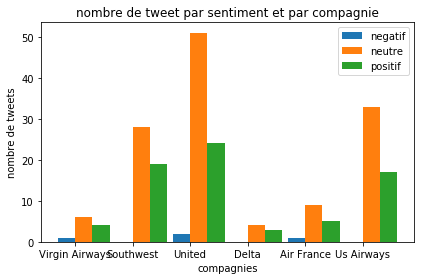

In [48]:
import matplotlib.pyplot as plt

pre_process_pipe = PreprocessingPipeline(True, True, True)
bow_tfidf = TFIDFBoW(pre_process_pipe, True, False)
print("data shape: trainX: {}, TrainY: {}, validX: {}, validY: {}".format(len(training_X),
                                                                         len(training_Y),
                                                                         len(validation_X),
                                                                         len(validation_Y)))

classifier = train_evaluate(training_X, training_Y, validation_X, validation_Y, bow_tfidf)[0]

airline_tweet = []
airline_index = []
i, j = 0, 0
for raw_tweet in extract_tweet_content("saved_tweets.txt"):
    if len(detect_airline(raw_tweet)):
        airline_tweet.append(raw_tweet)
        airline_index.append(detect_airline(raw_tweet))
        i +=1
    j +=1
print("{} tweets selectionnés sur {}".format(i, j))
airline_ls = []
for index in airline_index:
    for compagnie in index:
        if compagnie not in airline_ls:
            airline_ls.append(compagnie)

bow_tweets = bow_tfidf.transform(airline_tweet)
sentiment_vector = [extract_sentiment(classifier, tweet) for tweet in bow_tweets]


def count_sentiment_tweet(sentiment, airline, airline_index, sentiment_vector):
    count = 0
    for i in range(len(sentiment_vector)):
        for airline_from_index in airline_index[i]:
            if sentiment_vector[i] == sentiment and airline_from_index == airline:
                count += 1
    return count

print("\nCompagnies: " + str(airline_ls))

fig, ax = plt.subplots()
bar_width = 0.3
negative = ax.bar(range(len(airline_ls)), [count_sentiment_tweet(0, airline, airline_index, sentiment_vector) for airline in airline_ls], bar_width, label = "negatif")
neutral = ax.bar(np.array(range(len(airline_ls))) + bar_width, [count_sentiment_tweet(1, airline, airline_index, sentiment_vector) for airline in airline_ls], bar_width,label = "neutre")
positive = ax.bar(np.array(range(len(airline_ls))) + bar_width * 2, [count_sentiment_tweet(2, airline, airline_index, sentiment_vector) for airline in airline_ls], bar_width,label = "positif")

ax.set_xlabel('compagnies')
ax.set_ylabel('nombre de tweets')
ax.set_title('nombre de tweet par sentiment et par compagnie')
ax.set_xticks(np.array(range(len(airline_ls))) + bar_width / 2)
ax.set_xticklabels(airline_ls)
ax.legend()

fig.tight_layout()
plt.show()

## 3.3 - Term Analysis

POS-tagging consists of extracting the part-of-speech (POS) of each token in a sentence. For instance, the table below depicts the part-of-speechs of the sentence *The cat is white!* are.



|   The   | cat  |  is  | white     |    !       |
|---------|------|------|-----------|------------|
| article | noun | verb | adjective | punctation |


The part-of-speech can be more complex than what we have learned in the school. Linguistics need to have a more detailed information about systax information of the words in a sentence. For our problem, we do not need this level of information and, thus, we will use a less complex set, called universal POS tags. 

In POS-tagging, each part-of-speech is represented by a tag. You can find the POS tag list used in this assignement at https://universaldependencies.org/u/pos/ .

In [25]:
# NLTK POS-tagger
import nltk

#before using pos_tag function, you have to tokenize the sentence.
s = ['The', 'cat', 'is',  'white', '!']
nltk.pos_tag(s,tagset='universal')


[('The', 'DET'), ('cat', 'NOUN'), ('is', 'VERB'), ('white', 'ADJ'), ('!', '.')]

### 3.3.1 Question 12 (2 points)

**Implement a code** that retrieves the top 10 most frequent terms for each airline company. You will only consider the terms that appear in a positive and negative tweets. Besides that, we consider as term:
1. Words that are either an adjective or a noun
2. n-grams that are composed by adjectives followed by a noun (e.g., dirty place) or a noun followed by another noun (e.g.,sports club).

Moreover, **generate a table** with the top 10 most frequent terms and their normalized frequencies(percentage) for each airline company.

**Do not forget to remove the company names from the chart.**

In [81]:
from scipy.sparse import csc_matrix

bow_count = CountBoW(pre_process_pipe, True, False)
bow_count.tokens_index = bow_tfidf.tokens_index
bow_count_tweets = bow_count.transform(airline_tweet)

bow_count_tweets = csr_matrix(bow_count_tweets)
bow_pos_and_neg = []
sentiment_vector_pos_and_neg = []
for index in range(len(sentiment_vector)):
    if sentiment_vector[index] == 0 or sentiment_vector[index] == 2:
        bow_pos_and_neg.append(bow_count_tweets.getrow(index).toarray()[0].tolist())
        sentiment_vector_pos_and_neg.append(sentiment_vector[index])
bow_pos_and_neg = csc_matrix(bow_pos_and_neg)
max_occurence_word_index = [0, 0, 0 ,0 ,0 ,0 ,0 ,0 ,0 ,0]
max_occurence_word_count = [0, 0, 0, 0, 0, 0 ,0 ,0 ,0 ,0]
print("token start list len: " + str(len(bow_count.tokens_index)))
for token_index in range(len(bow_count.tokens_index)):
    selected = False
    words = tk.tokenize(bow_count.tokens_index[token_index])
    if len(words) == 1:
        type_wd = nltk.pos_tag(words, tagset='universal')[0][1]
        if type_wd == "ADJ" or type_wd == "NOUN":
            selected = True
    elif len(words) == 2:
        type_wd_1 = nltk.pos_tag(words[0], tagset='universal')[0][1]
        type_wd_2 = nltk.pos_tag(words[1], tagset='universal')[0][1]
        if (type_wd_1 == "ADJ" or type_wd_1 == "NOUN") and type_wd_2 == "NOUN":
            selected = True
    if selected:
        column = bow_pos_and_neg.getcol(token_index)
        for word_occ_index in range(0, 9):
            if max_occurence_word_count[word_occ_index] < column.sum():
                index_min = max_occurence_word_count.index(min(max_occurence_word_count))
                max_occurence_word_index[index_min] = token_index
                max_occurence_word_count[index_min] = column.sum()
                break
print('top words: ' + str([bow_count.tokens_index[token_index] for token_index in max_occurence_word_index]))
print('max_occurence_word_index: ' + str(max_occurence_word_index))
print('occurence top words: ' + str(max_occurence_word_count))

bow_tweets = csc_matrix(bow_tweets)
table = []
for index in max_occurence_word_index:
    col = bow_tweets.getcol(index)
    table.append(col.toarray().squeeze().tolist())
    print(table)


token start list len: 4837
top words: ['i', 'cancel', 'miss', 'flight', "do n't", 'air', 've', 'wait', 'thank', 'u']
max_occurence_word_index: [8, 4414, 506, 4480, 520, 1354, 847, 4444, 917, 273]
occurence top words: [41, 13, 6, 33, 6, 6, 5, 5, 9, 6]
[[0.0, 2.235613471848514, 0.0, 1.117806735924257, 0.0, 1.117806735924257, 0.0, 0.0, 0.0, 0.0, 0.0, 1.117806735924257, 0.0, 0.0, 0.0, 1.117806735924257, 1.117806735924257, 0.0, 1.117806735924257, 0.0, 0.0, 0.0, 0.0, 0.0, 1.117806735924257, 1.117806735924257, 0.0, 0.0, 2.235613471848514, 1.117806735924257, 0.0, 0.0, 0.0, 0.0, 0.0, 1.117806735924257, 2.235613471848514, 0.0, 0.0, 1.117806735924257, 0.0, 0.0, 1.117806735924257, 0.0, 3.353420207772771, 4.471226943697028, 2.235613471848514, 1.117806735924257, 0.0, 3.353420207772771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.117806735924257, 2.235613471848514, 1.117806735924257, 1.117806735924257, 1.117806735924257, 0.0, 0.0, 1.117806735924257, 1.117806735924257, 0.0, 0.0, 1.117806735924257, 

### 3.3.2 Question 13 (1 point)

The table generated in the Question 12 can lead us to any conclusion about each one of the 9 companies? Can we identify specific events that have occured during the data retrieval?

# 4 - Bonus (2 points)

Person names, companies names and locations are called named entities. Named-entity recognition (NER) is the task of extracting named entities  classifying them using pre-defined categories. In this bonus section, you will use a Named Entity Recognizer to automatically extract named entities from the tweets. This approach is generic enough to retrieve information about other companies or even product and people names.

**For the bonus, you are free to use any Named Entity Recognizer that has python wrapper or is implemented in python. Moreover, you have to use the tweet database of the previous section (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing)**


## 4.1 - Bonus 2 (1 point)

Implement a code that generates the table with the top 10 most mentioned named entities in the database (this table has to contain the frequencies of the name entities). After that, generates a bar chart that despicts the number of positive, negative and neutral tweets for each one of these 10 named entities. Briefly describe the results found in the bar chart.

*Ignore the named entities related to the following airline companies : Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.*

## 4.2 - Bonus 3 (1 point)

Generate a similar table produced in the Question 12 for the 10 most mentioned named entities in Bonus 2. Can we draw any conclusion about these named entities?